# Stock prediction using XGBoost

## Import libraries and get sample data

In [0]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "google_stock_data.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14


In [0]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [66]:
df = pd.read_csv(stk_path, sep = ",")

# # Convert Date column to datetime
# df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# # Change all column headings to be lower case, and remove spacing
# df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# # Get month of each sample
# df['month'] = df['date'].dt.month

# # Sort by datetime
# df.sort_values(by='date', inplace=True, ascending=True)

df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3804,2019-09-30,1220.969971,1226.000000,1212.300049,1219.000000,1219.000000,1404100
3805,2019-10-01,1219.000000,1231.229980,1203.579956,1205.099976,1205.099976,1273500
3806,2019-10-02,1196.979980,1196.979980,1171.290039,1176.630005,1176.630005,1615100
3807,2019-10-03,1180.000000,1189.060059,1162.430054,1187.829956,1187.829956,1621200
3808,2019-10-04,1191.890015,1211.439941,1189.170044,1209.000000,1209.000000,1021092


Text(0, 0.5, 'Stock_Price')

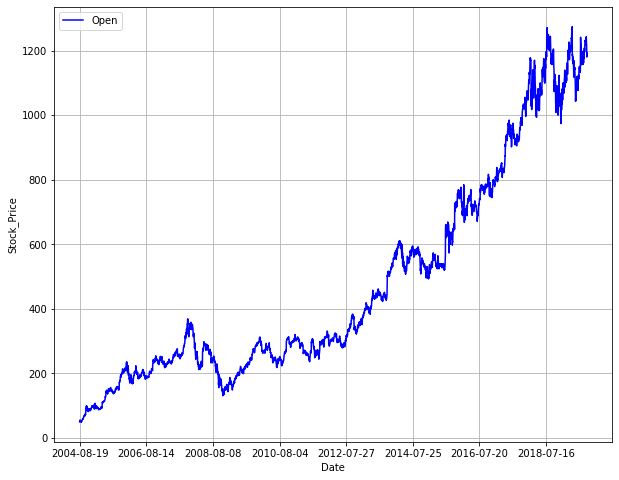

In [67]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Open', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("Stock_Price")

In [68]:
# Get sizes of each of the datasets
# num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_test
print("num_train = " + str(num_train))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
test = df[num_train:]
print("train.shape = " + str(train.shape))
print("test.shape = " + str(test.shape))

num_train = 3048
num_test = 761
train.shape = (3048, 7)
test.shape = (761, 7)


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3809 entries, 0 to 3808
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3809 non-null   object 
 1   Open       3809 non-null   float64
 2   High       3809 non-null   float64
 3   Low        3809 non-null   float64
 4   Close      3809 non-null   float64
 5   Adj Close  3809 non-null   float64
 6   Volume     3809 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 208.4+ KB


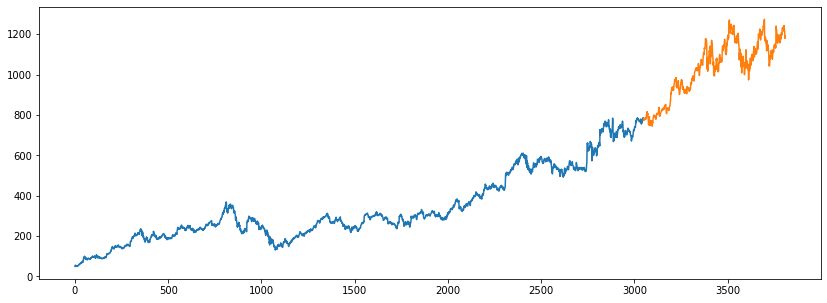

In [70]:
# Plot adjusted close over time
# rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# ax = train.plot(x='Date', y='Adj Close', style='b-', grid=True)
# ax = test.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)


plt.figure(figsize=(14,5))
#plotting the data
train['Open'].plot()
test['Open'].plot()
# ax.legend(['train', 'test'])
# ax.set_xlabel("Date")
# ax.set_ylabel("USD")
# ax.set_title("Without scaling")

In [71]:
features = ["Adj Close", "High", "Low", "Close"]
target = "Open"
# Split into X and y
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))

print("X_test.shape = " + str(X_test.shape))
print("y_test.shape = " + str(y_test.shape))


X_train.shape = (3048, 4)
y_train.shape = (3048,)
X_test.shape = (761, 4)
y_test.shape = (761,)


In [72]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train, y_train)

[05:51:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

In [0]:
# Do prediction on train set
y_pred = model.predict(X_train)

Text(0.5, 1.0, 'Without scaling')

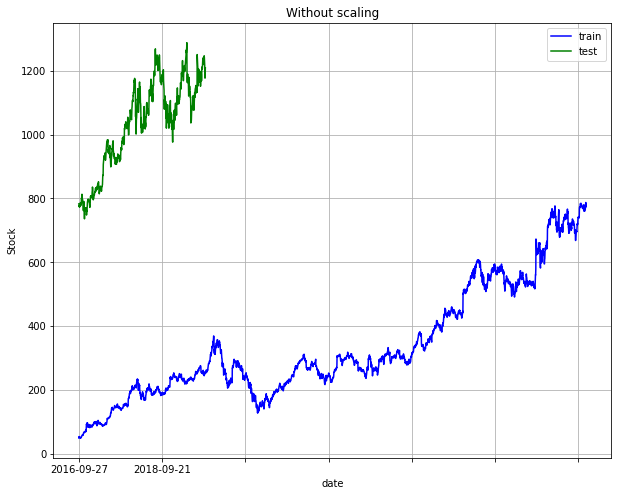

In [82]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax = test.plot(x='Date', y='Adj Close', style='g-', grid=True, ax=ax)
ax.legend(['train','test'])
ax.set_xlabel("date")
ax.set_ylabel("Stock")
ax.set_title("Without scaling")

In [32]:
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)
df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2004-08-19,49.982655,44871300,8,4.034878,-0.169369
1,2004-08-20,53.952770,22942800,8,4.273979,-3.636368
2,2004-08-23,54.495735,18342800,8,2.206730,0.672482
3,2004-08-24,52.239193,15319700,8,4.000008,3.173107
4,2004-08-25,52.802086,9232100,8,2.052307,-0.518059


In [33]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [7]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2004-08-24,52.239193,15319700,8,4.000008,3.173107,3,54.495735,2.206730,0.672482,18342800.0,53.952770,4.273979,-3.636368,22942800.0,49.982655,4.034878,-0.169369,44871300.0
4,2004-08-25,52.802086,9232100,8,2.052307,-0.518059,4,52.239193,4.000008,3.173107,15319700.0,54.495735,2.206730,0.672482,18342800.0,53.952770,4.273979,-3.636368,22942800.0
5,2004-08-26,53.753517,7128600,8,1.638859,-1.474472,5,52.802086,2.052307,-0.518059,9232100.0,52.239193,4.000008,3.173107,15319700.0,54.495735,2.206730,0.672482,18342800.0
6,2004-08-27,52.876804,6241200,8,1.459530,0.971360,6,53.753517,1.638859,-1.474472,7128600.0,52.802086,2.052307,-0.518059,9232100.0,52.239193,4.000008,3.173107,15319700.0
7,2004-08-30,50.814533,5221400,8,1.733505,1.628895,7,52.876804,1.459530,0.971360,6241200.0,53.753517,1.638859,-1.474472,7128600.0,52.802086,2.052307,-0.518059,9232100.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3809 entries, 0 to 3808
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3809 non-null   datetime64[ns]
 1   adj_close  3809 non-null   float64       
 2   volume     3809 non-null   int64         
 3   month      3809 non-null   int64         
 4   range_hl   3809 non-null   float64       
 5   range_oc   3809 non-null   float64       
 6   order_day  3809 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 238.1 KB


In [35]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
0,2004-08-19,49.982655,44871300,8,4.034878,-0.169369,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-08-20,53.952770,22942800,8,4.273979,-3.636368,1,49.982655,NaN,4.034878,NaN,-0.169369,NaN,4.487130e+07,NaN
2,2004-08-23,54.495735,18342800,8,2.206730,0.672482,2,51.967712,2.807295,4.154428,0.169070,-1.902868,2.451539,3.390705e+07,1.550579e+07
3,2004-08-24,52.239193,15319700,8,4.000008,3.173107,3,52.810387,2.463890,3.505196,1.130841,-1.044418,2.283819,2.871897e+07,1.417616e+07
4,2004-08-25,52.802086,9232100,8,2.052307,-0.518059,4,53.562566,1.177790,3.493572,1.122826,0.069740,3.444519,1.886843e+07,3.838637e+06


In [36]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 2287
num_cv = 761
num_test = 761
train.shape = (2287, 15)
cv.shape = (761, 15)
train_cv.shape = (3048, 15)
test.shape = (761, 15)


In [11]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [2.48765523e+02 2.48592372e+02 5.37617982e+00 1.11901259e-01
 1.06486160e+07 2.48422736e+02 5.37643936e+00 1.10025624e-01
 1.06575541e+07 2.48251003e+02 5.37556043e+00 1.08110728e-01
 1.06760254e+07]
scaler.var_ = [7.03271118e+03 7.03147986e+03 9.85979779e+00 1.37503724e+01
 7.75374205e+13 7.03176176e+03 9.85907173e+00 1.37563945e+01
 7.75746461e+13 7.03252918e+03 9.85966480e+00 1.37490858e+01
 7.80589745e+13]
train_scaled.shape = (2284, 13)
train_scaled.shape = (2284, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-2.343470,-2.314700,-1.009369,0.151175,0.873790,-2.319105,-0.351111,-1.010092,1.394839,-2.364273,-0.426968,-0.074833,3.870390,2004-08-24,8
1,-2.336758,-2.341610,-0.438267,0.825535,0.530471,-2.312630,-1.009489,0.151648,0.872565,-2.316931,-0.350821,-1.009844,1.388414,2004-08-25,8
2,-2.325412,-2.334897,-1.058548,-0.169885,-0.160867,-2.339540,-0.438366,0.825860,0.529329,-2.310456,-1.009178,0.152205,0.867763,2004-08-26,8
3,-2.335867,-2.323551,-1.190218,-0.427807,-0.399750,-2.332827,-1.058669,-0.169342,-0.161843,-2.337365,-0.438073,0.826596,0.525594,2004-08-27,8
4,-2.360458,-2.334006,-1.247328,0.231776,-0.500528,-2.321481,-1.190344,-0.427208,-0.400669,-2.330652,-1.058357,-0.168871,-0.163431,2004-08-30,8


In [14]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [3.38920046e+02 3.38683686e+02 6.62386983e+00 1.41105179e-01
 8.56542089e+06 3.38442981e+02 6.62370366e+00 1.40012775e-01
 8.57249179e+06 3.38200870e+02 6.62128163e+00 1.42324976e-01
 8.58673977e+06]
scaler_train_cv.var_ = [3.17613186e+04 3.17256043e+04 2.03967726e+01 2.30584386e+01
 7.17954689e+13 3.16861945e+04 2.03974695e+01 2.30630568e+01
 7.18464982e+13 3.16473239e+04 2.03921413e+01 2.30453413e+01
 7.22625145e+13]
train_cv_scaled.shape = (3045, 13)
train_cv_scaled.shape = (3045, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.608605,-1.595514,-0.978049,0.110659,1.153915,-1.598204,-0.520270,-0.786353,1.695365,-1.620141,-0.572750,-0.064929,4.268402,2004-08-24,8
1,-1.605447,-1.608183,-0.580979,0.631414,0.797132,-1.595154,-0.977995,0.110876,1.152671,-1.597824,-0.519802,-0.787136,1.688802,2004-08-25,8
2,-1.600108,-1.605023,-1.012241,-0.137271,0.078681,-1.607831,-0.580932,0.631579,0.796015,-1.594772,-0.977586,0.110437,1.147672,2004-08-26,8
3,-1.605027,-1.599681,-1.103787,-0.336444,-0.169572,-1.604669,-1.012187,-0.137030,0.077819,-1.607457,-0.580472,0.631340,0.792044,2004-08-27,8
4,-1.616599,-1.604603,-1.143495,0.172901,-0.274302,-1.599324,-1.103732,-0.336183,-0.170346,-1.604293,-1.011783,-0.137564,0.075918,2004-08-30,8


In [15]:

# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2287,2013-09-19,1.150334,-0.662049,-0.488285,1.083480,-0.887504,-0.195977,-1.111029,0.283099,0.827931,1.148410,-0.678445,-0.469965
2288,2013-09-20,0.276441,0.832699,-1.109140,-0.335693,1.124655,-0.788962,0.806317,-1.118973,0.312656,0.001574,0.999212,-1.000786
2289,2013-09-23,0.539272,-1.153881,0.614609,-0.726958,-0.413470,1.140428,-0.001897,1.000947,-0.999050,1.147384,-0.686086,-0.461298
2290,2013-09-24,-1.109939,0.830699,0.279240,1.116629,-0.812982,-0.303647,0.704183,-1.144616,0.440433,-0.517963,1.152730,-0.634766
2291,2013-09-25,-0.559349,-0.595166,1.154515,-0.556099,1.154443,-0.598344,-0.253899,1.102476,-0.848577,-0.667246,-0.482518,1.149765


In [16]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
3048,2016-09-27,-1.154448,0.556328,0.598120,0.305460,-1.117106,0.811646,1.038457,-0.081959,-0.956498,0.917268,-1.066058,0.148790
3049,2016-09-28,0.251740,-1.101816,0.850076,0.837092,0.270263,-1.107355,-0.964241,1.032284,-0.068043,-1.096880,0.860914,0.235966
3050,2016-09-29,0.416829,0.724157,-1.140986,-1.051320,0.939235,0.112085,-0.335644,-0.789000,1.124643,-0.667999,-0.481680,1.149679
3051,2016-09-30,-1.137874,0.398841,0.739033,0.556597,-1.154455,0.597858,1.113843,-0.293264,-0.820579,1.131140,-0.766545,-0.364595
3052,2016-10-03,-0.199504,-0.885209,1.084713,-0.575525,1.154699,-0.579173,-0.294936,1.114298,-0.819362,1.042744,-0.091822,-0.950922


Text(0.5, 1.0, 'Without scaling')

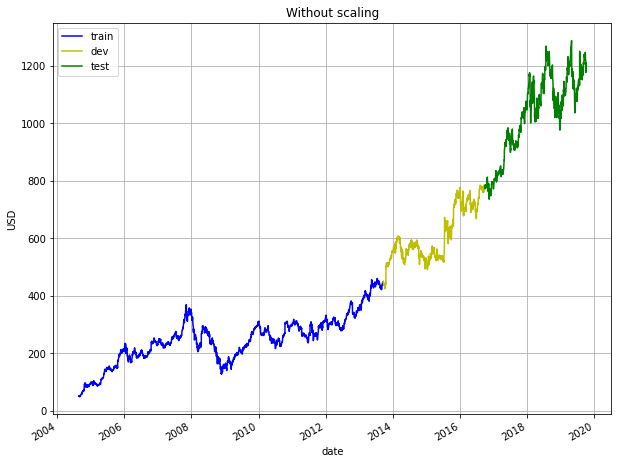

In [18]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

In [12]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (2284, 12)
y_train.shape = (2284,)
X_cv.shape = (761, 12)
y_cv.shape = (761,)
X_train_cv.shape = (3045, 12)
y_train_cv.shape = (3045,)
X_sample.shape = (761, 12)
y_sample.shape = (761,)


In [0]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"





In [17]:
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (2284, 12)
y_train_scaled.shape = (2284,)
X_cv_scaled.shape = (761, 12)
X_train_cv_scaled.shape = (3045, 12)
y_train_cv_scaled.shape = (3045,)
X_sample_scaled.shape = (761, 12)


In [19]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

[04:44:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

In [20]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 3.963
MAPE on train set = 1.222%


Text(0.5, 1.0, 'Without scaling')

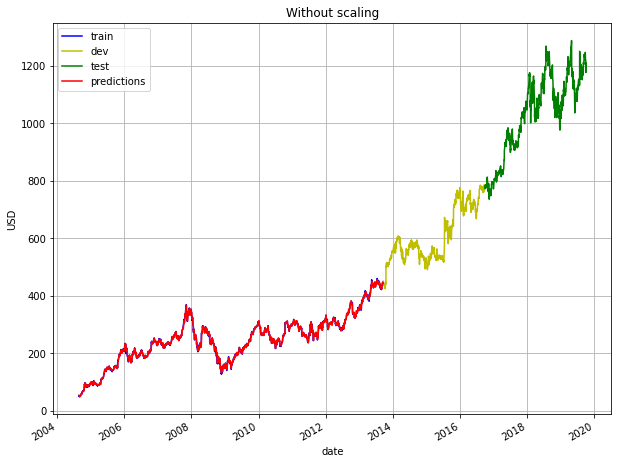

In [22]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [23]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 9.467
MAPE on dev set = 1.033%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'USD')

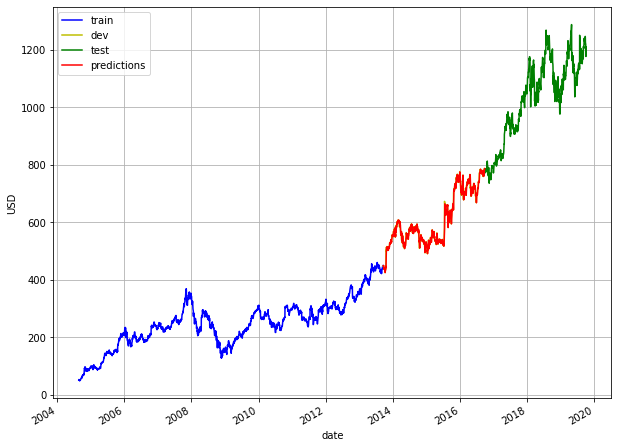

In [24]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

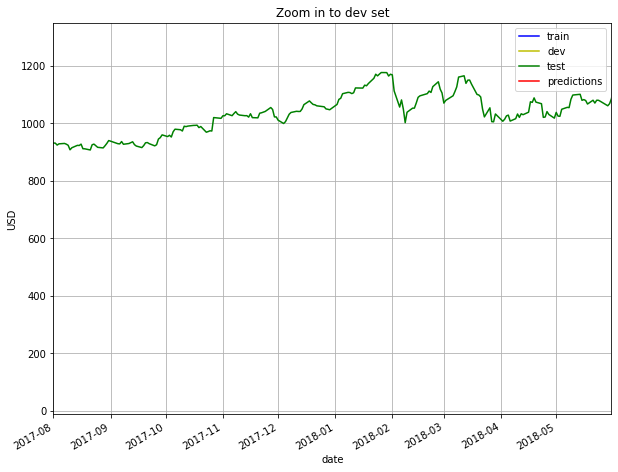

In [25]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 8, 1), date(2018, 5, 31)])
ax.set_title("Zoom in to dev set")